In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the visual style for professional graphs (we will use this later)
sns.set_theme(style="white", context="talk")

# Load the dataset
# Make sure '7210_1.csv' is in the same folder as this notebook
try:
    df = pd.read_csv('7210_1.csv', low_memory=False)
    print("✅ Success! Data loaded.")
    print(f"Dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print("❌ Error: File '7210_1.csv' not found. Please check the folder.")

✅ Success! Data loaded.
Dimensions: 33801 rows, 52 columns


In [2]:
# 1. Inspect the columns we actually care about
# We only care about 'brand' and 'prices.amountMin' (the price)
target_cols = ['brand', 'prices.amountMin']

print("\n--- SNAPSHOT OF RAW DATA ---")
print(df[target_cols].head())

print("\n--- MISSING VALUE CHECK ---")
# Check how many missing values are in our key columns
print(df[target_cols].isnull().sum())

print("\n--- DATA TYPE CHECK ---")
# Check if Price is actually a number (float) or text (object)
print(df[target_cols].dtypes)


--- SNAPSHOT OF RAW DATA ---
    brand  prices.amountMin
0  Novica             62.99
1  Novica             62.99
2  Novica             62.99
3  Novica             62.99
4  Novica             62.99

--- MISSING VALUE CHECK ---
brand               984
prices.amountMin      0
dtype: int64

--- DATA TYPE CHECK ---
brand                object
prices.amountMin    float64
dtype: object


In [3]:
# Create a copy so we don't mess up the original dataframe
df_clean = df.copy()

# 1. FIX PRICES (Convert Text to Numbers)
# 'errors=coerce' turns any text (like "$50" or "Contact for price") into NaN (Not a Number)
df_clean['price'] = pd.to_numeric(df_clean['prices.amountMin'], errors='coerce')

# Drop rows where price is missing (we can't analyze shoes without a price!)
df_clean = df_clean.dropna(subset=['price'])

# 2. FIX BRANDS (Standardize Names)
# Lowercase everything first
df_clean['brand_clean'] = df_clean['brand'].str.lower().str.strip()

# Define our cleaning logic
# If it contains 'nike', call it 'nike'. If it's a weird adidas variant, call it 'adidas'.
def clean_brand_name(name):
    if not isinstance(name, str): return "other"
    if 'nike' in name:
        return 'nike'
    elif name in ['adi', 'addidas', 'addidas outdoor', 'adidas']:
        return 'adidas'
    else:
        return 'other' # We will ignore these later

df_clean['brand_group'] = df_clean['brand_clean'].apply(clean_brand_name)

# Filter for ONLY the two brands we are studying
df_final = df_clean[df_clean['brand_group'].isin(['nike', 'adidas'])].copy()

print(f"✅ Cleaning Complete.")
print(f"Final Dataset Size: {len(df_final)} shoes")
print(df_final['brand_group'].value_counts())

✅ Cleaning Complete.
Final Dataset Size: 873 shoes
brand_group
nike      656
adidas    217
Name: count, dtype: int64


/var/folders/c0/ffhr5hg55hx3vmc9g90tjxzm0000gn/T/ipykernel_55976/355106091.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


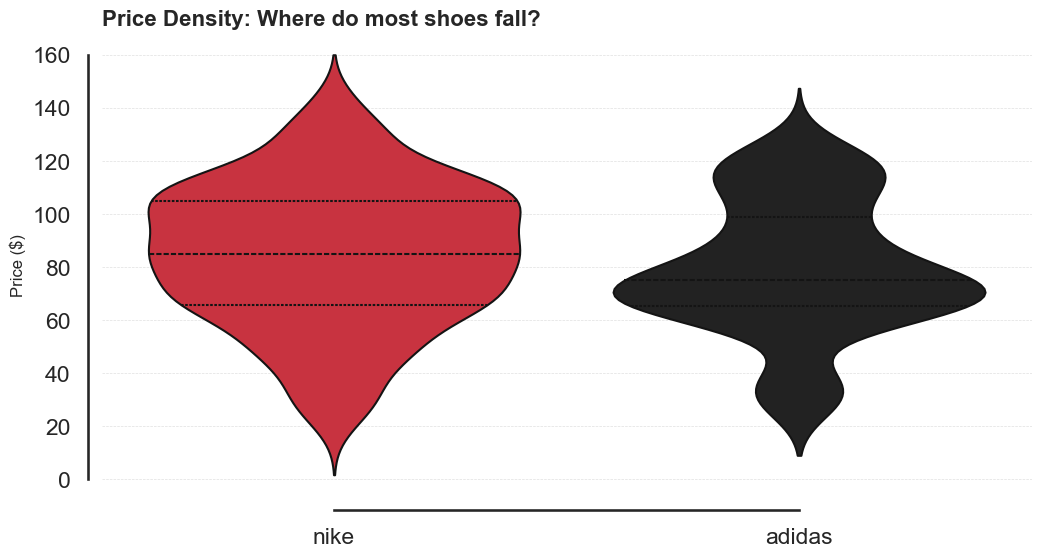

/var/folders/c0/ffhr5hg55hx3vmc9g90tjxzm0000gn/T/ipykernel_55976/355106091.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


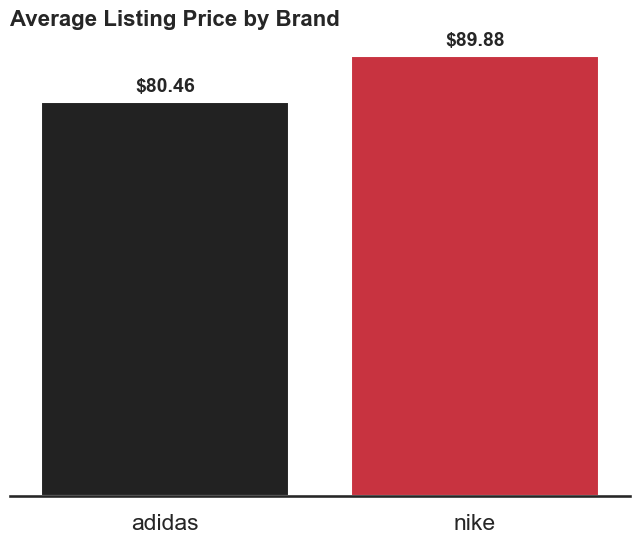

In [4]:
# --- SETTING THE STAGE ---
# Define brand colors: Nike Red and Adidas Black
brand_colors = {"nike": "#E11A2B", "adidas": "#222222"}

# --- CHART 1: THE VIOLIN PLOT (Price Distribution) ---
plt.figure(figsize=(12, 6))

# We zoom in to ignore extreme luxury outliers (top 5%) for the graph only
# This makes the main "blob" of data easier to see
upper_limit = df_final['price'].quantile(0.95)
df_zoom = df_final[df_final['price'] < upper_limit]

ax = sns.violinplot(
    data=df_zoom,
    x="brand_group",
    y="price",
    palette=brand_colors,
    inner="quartile", # Draws the median and quartiles inside the violin
    linewidth=1.5
)

# Professional Polish
sns.despine(offset=10, trim=True) # Remove top/right/left spines
ax.yaxis.grid(True, color='#E0E0E0', linestyle='--', linewidth=0.5) # Add faint grid
ax.xaxis.grid(False)

plt.title("Price Density: Where do most shoes fall?", fontsize=16, fontweight='bold', loc='left')
plt.xlabel("") # Brand names are obvious, no label needed
plt.ylabel("Price ($)", fontsize=12)
plt.show()

# --- CHART 2: THE BAR CHART (Mean Comparison) ---
# Calculate means first
summary = df_final.groupby('brand_group')['price'].mean().reset_index()

plt.figure(figsize=(8, 6))
ax2 = sns.barplot(
    data=summary,
    x='brand_group',
    y='price',
    palette=brand_colors
)

# Professional Polish
sns.despine(left=True) # Remove left axis line completely
ax2.yaxis.set_visible(False) # Hide Y-axis numbers (we will put labels on bars)

plt.title("Average Listing Price by Brand", fontsize=16, fontweight='bold', loc='left')
plt.xlabel("")

# Add the numbers directly on top of the bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='$%.2f', padding=5, fontsize=14, fontweight='bold')

plt.show()

In [5]:
from scipy import stats

# --- STEP 1: PREPARE THE DATA ARRAYS ---
nike_prices = df_final[df_final['brand_group'] == 'nike']['price']
adidas_prices = df_final[df_final['brand_group'] == 'adidas']['price']

print(f"Comparing {len(nike_prices)} Nike shoes vs {len(adidas_prices)} Adidas shoes.\n")

# --- STEP 2: DIAGNOSTIC (NORMALITY CHECK) ---
# We use Shapiro-Wilk test.
# H0: Data is Normal. H1: Data is NOT Normal.
# If p < 0.05, we reject H0 (Data is not normal).

shapiro_nike = stats.shapiro(nike_prices)
shapiro_adidas = stats.shapiro(adidas_prices)

print(f"Normality (Nike) p-value:   {shapiro_nike.pvalue:.5f}")
print(f"Normality (Adidas) p-value: {shapiro_adidas.pvalue:.5f}")

# --- STEP 3: SELECT & RUN THE TEST ---
alpha = 0.05

print("\n--- TEST RESULTS ---")

# LOGIC TREE:
# If BOTH are normal -> Use T-Test
# If EITHER is not normal -> Use Mann-Whitney U Test (Non-Parametric)

if shapiro_nike.pvalue > alpha and shapiro_adidas.pvalue > alpha:
    print("✅ Assumption Met: Data is Normal.")
    print("👉 Running Independent T-Test...")
    # variances might be different, so we use Welch's T-test (equal_var=False) just to be safe
    stat, p_val = stats.ttest_ind(nike_prices, adidas_prices, equal_var=False)
    test_name = "Welch's T-Test"
else:
    print("⚠️ Assumption FAILED: Data is NOT Normal.")
    print("👉 Running Mann-Whitney U Test (Non-Parametric)...")
    stat, p_val = stats.mannwhitneyu(nike_prices, adidas_prices, alternative='two-sided')
    test_name = "Mann-Whitney U Test"

print(f"\nResults for {test_name}:")
print(f"Statistic: {stat:.3f}")
print(f"P-Value:   {p_val:.10f}")  # formatted to see very small numbers

print("\n--- FINAL VERDICT ---")
if p_val < alpha:
    print("🎉 REJECT H0. The price difference is STATISTICALLY SIGNIFICANT.")
    print("Conclusion: The $9.42 difference is real, not just luck.")
else:
    print("✋ FAIL TO REJECT H0. The difference is NOT statistically significant.")
    print("Conclusion: We cannot prove one brand is more expensive.")

Comparing 656 Nike shoes vs 217 Adidas shoes.

Normality (Nike) p-value:   0.00000
Normality (Adidas) p-value: 0.00000

--- TEST RESULTS ---
⚠️ Assumption FAILED: Data is NOT Normal.
👉 Running Mann-Whitney U Test (Non-Parametric)...

Results for Mann-Whitney U Test:
Statistic: 83370.000
P-Value:   0.0001524121

--- FINAL VERDICT ---
🎉 REJECT H0. The price difference is STATISTICALLY SIGNIFICANT.
Conclusion: The $9.42 difference is real, not just luck.


In [ ]:
import numpy as np

# --- STEP 4: EFFECT SIZE (Cohen's d) ---

def cohens_d(group1, group2):
    # Calculate difference between means
    diff = group1.mean() - group2.mean()

    # Calculate pooled standard deviation
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()

    # Formula for Pooled SD
    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    pooled_sd = np.sqrt(pooled_var)

    # Cohen's d
    return diff / pooled_sd

# Calculate
d_value = cohens_d(nike_prices, adidas_prices)

print(f"Cohen's d: {d_value:.4f}")

print("\n--- INTERPRETATION ---")
if abs(d_value) < 0.2:
    print("Effect Size: NEGLIGIBLE. (Statistical difference exists, but it's tiny in reality)")
elif abs(d_value) < 0.5:
    print("Effect Size: SMALL. (Noticeable, but overlap is large)")
elif abs(d_value) < 0.8:
    print("Effect Size: MEDIUM. (Clearly visible difference)")
else:
    print("Effect Size: LARGE. (The two groups are very distinct)")

Cohen's d: 0.2974

--- INTERPRETATION ---
Effect Size: SMALL. (Noticeable, but overlap is large)
